[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/nbs/connected_components.ipynb)

# Connected Components Algorithm

In this tutorial we are going to learn how to segment small objects in the image using the kornia implementation of the classic Computer Vision technique called **[Connected-component labelling (CCL)](https://en.wikipedia.org/wiki/Connected-component_labeling)**.

In [ ]:
%%capture
!pip install kornia

In [ ]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


url = "https://github.com/kornia/data/raw/main/cells_binary.png"
download_image(url)

'cells_binary.png'

In [ ]:
from typing import Dict, Tuple

import cv2
import kornia as K
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

We define utility functions to visualize the segmentation properly

In [ ]:
def create_random_labels_map(classes: int) -> Dict[int, Tuple[int, int, int]]:
    labels_map: Dict[int, Tuple[int, int, int]] = {}
    for i in classes:
        labels_map[i] = torch.randint(0, 255, (3,))
    labels_map[0] = torch.zeros(3)
    return labels_map


def labels_to_image(img_labels: torch.Tensor, labels_map: Dict[int, Tuple[int, int, int]]) -> torch.Tensor:
    """Function that given an image with labels ids and their pixels intrensity mapping, creates a RGB
    representation for visualisation purposes."""
    assert len(img_labels.shape) == 2, img_labels.shape
    H, W = img_labels.shape
    out = torch.empty(3, H, W, dtype=torch.uint8)
    for label_id, label_val in labels_map.items():
        mask = img_labels == label_id
        for i in range(3):
            out[i].masked_fill_(mask, label_val[i])
    return out


def show_components(img, labels):
    color_ids = torch.unique(labels)
    labels_map = create_random_labels_map(color_ids)
    labels_img = labels_to_image(labels, labels_map)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

    # Showing Original Image
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.axis("off")
    ax1.set_title("Orginal Image")

    # Showing Image after Component Labeling
    ax2.imshow(labels_img.permute(1, 2, 0).squeeze().numpy())
    ax2.axis("off")
    ax2.set_title("Component Labeling")

We load the image using OpenCV and we ensure that is a floating point image within the range of [0, 1].

In [ ]:
img: np.ndarray = cv2.imread("cells_binary.png", cv2.IMREAD_GRAYSCALE)

Cast the input image to a `torch.tensor`

In [ ]:
img_t: torch.Tensor = K.utils.image_to_tensor(img)  # CxHxW
img_t = img_t[None, ...].float() / 255.0
print(img_t.shape)

torch.Size([1, 1, 602, 602])


Apply the Connected-component labelling algorithm using the `kornia.contrib.connected_components` functionality. The `num_iterations` parameter will control the total number of iterations of the algorithm to finish until it converges to a solution.

In [ ]:
labels_out = K.contrib.connected_components(img_t, num_iterations=150)
print(labels_out.shape)

torch.Size([1, 1, 602, 602])


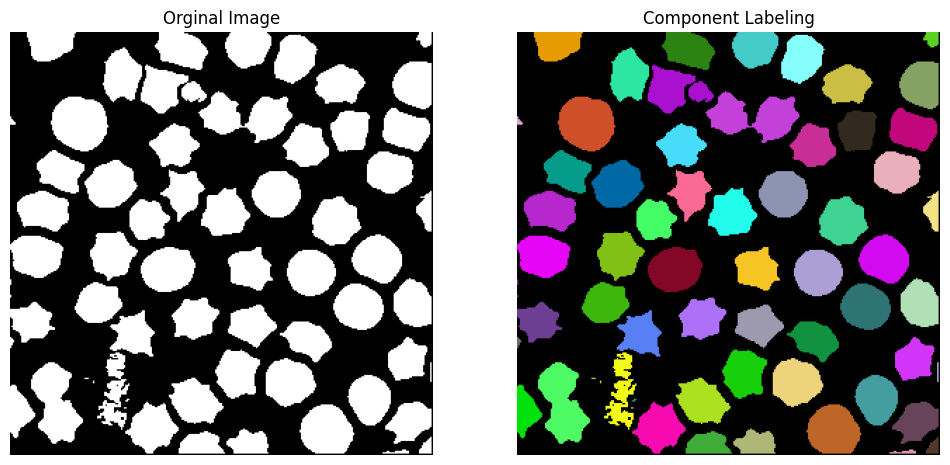

In [ ]:
show_components(img_t.numpy().squeeze(), labels_out.squeeze())

We can also explore the labels

In [ ]:
print(torch.unique(labels_out))

tensor([     0.,  13235.,  24739.,  31039.,  32177.,  44349.,  59745.,  61289.,
         66209.,  69449.,  78869.,  94867., 101849., 102217., 102319., 115227.,
        115407., 137951., 138405., 150047., 158715., 162179., 170433., 170965.,
        174279., 177785., 182867., 210145., 212647., 215451., 216119., 221291.,
        222367., 226183., 226955., 248757., 252823., 255153., 263337., 265505.,
        270299., 270649., 277725., 282775., 296897., 298545., 299793., 300517.,
        313961., 316217., 321259., 322235., 335599., 337037., 340289., 347363.,
        352235., 352721., 360801., 360903., 360965., 361073., 361165., 361197.])
